# EDT only, scaled FI and normal labels

### note: the colorbar labels on the prediction images are incorrect and should read 'normalized EDT feature input' instead of 'EDT [m]'

## modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import time

2023-12-12 15:24:54.288908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 15:24:54.853383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## loss plot function

In [2]:
def learning_progress(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)
    ground_iou = history.history["binary_io_u"]
    val_ground_iou = history.history["val_binary_io_u"]
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.set_dpi(200)
    ax[0].semilogy(epochs, loss, "b", label="Training loss")
    ax[0].plot(epochs, val_loss, "r", label="Validation loss")
    ax[0].set_title("Training and validation loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].grid()
    ax[0].legend()
    ax[1].plot(epochs, ground_iou, "b", label="Training IoU")
    ax[1].plot(epochs, val_ground_iou, "r", label="Validation IoU")
    ax[1].set_title("Training and validation IoU")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("IoU")
    ax[1].grid()
    ax[1].legend()
    plt.show()

## EDT2

In [3]:
kf = 0

data = np.load("../labelmaking/all_scaled_EDT2_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0][kf::2]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0][kf::2]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0][kf::2]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0][kf::2]
y_test = np.expand_dims(y_test, axis=-1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# unet architecture
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        input
    )
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# parameters 
input_shape = x_train.shape[1:]
batch_size = 64
learning_rate = 0.001
epochs = 50

model = build_unet(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)],
)

checkpoint_filepath = 'edt2_64'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback],
)

(2390, 128, 128, 1)
(597, 128, 128, 1)
(2390, 128, 128, 1)
(597, 128, 128, 1)


2023-10-05 13:34:08.188800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 13:34:08.226454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 13:34:08.226778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-10-05 13:34:13.582959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 13:34:13.724314: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 13:34:18.160410: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x300f9e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 13:34:18.160436: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-10-05 13:34:18.182622: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-05 13:34:18.280899: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 13:34:18.329997: I ./tensorflow/compiler/jit/device_compiler.h:186] 

38/38 [==============================] - 52s 800ms/step - loss: 0.2552 - binary_io_u: 0.1931 - val_loss: 0.8273 - val_binary_io_u: 0.0314
Epoch 2/50
38/38 [==============================] - 24s 632ms/step - loss: 0.0911 - binary_io_u: 0.5950 - val_loss: 0.2865 - val_binary_io_u: 0.0000e+00
Epoch 3/50
38/38 [==============================] - 24s 645ms/step - loss: 0.0651 - binary_io_u: 0.6524 - val_loss: 0.1829 - val_binary_io_u: 0.0000e+00
Epoch 4/50
38/38 [==============================] - 24s 641ms/step - loss: 0.0514 - binary_io_u: 0.6953 - val_loss: 0.1512 - val_binary_io_u: 0.0000e+00
Epoch 5/50
38/38 [==============================] - 24s 643ms/step - loss: 0.0392 - binary_io_u: 0.7612 - val_loss: 0.1417 - val_binary_io_u: 0.0000e+00
Epoch 6/50
38/38 [==============================] - 24s 639ms/step - loss: 0.0310 - binary_io_u: 0.8054 - val_loss: 0.1411 - val_binary_io_u: 0.0000e+00
Epoch 7/50
38/38 [==============================] - 17s 457ms/step - loss: 0.0270 - binary_io_u: 

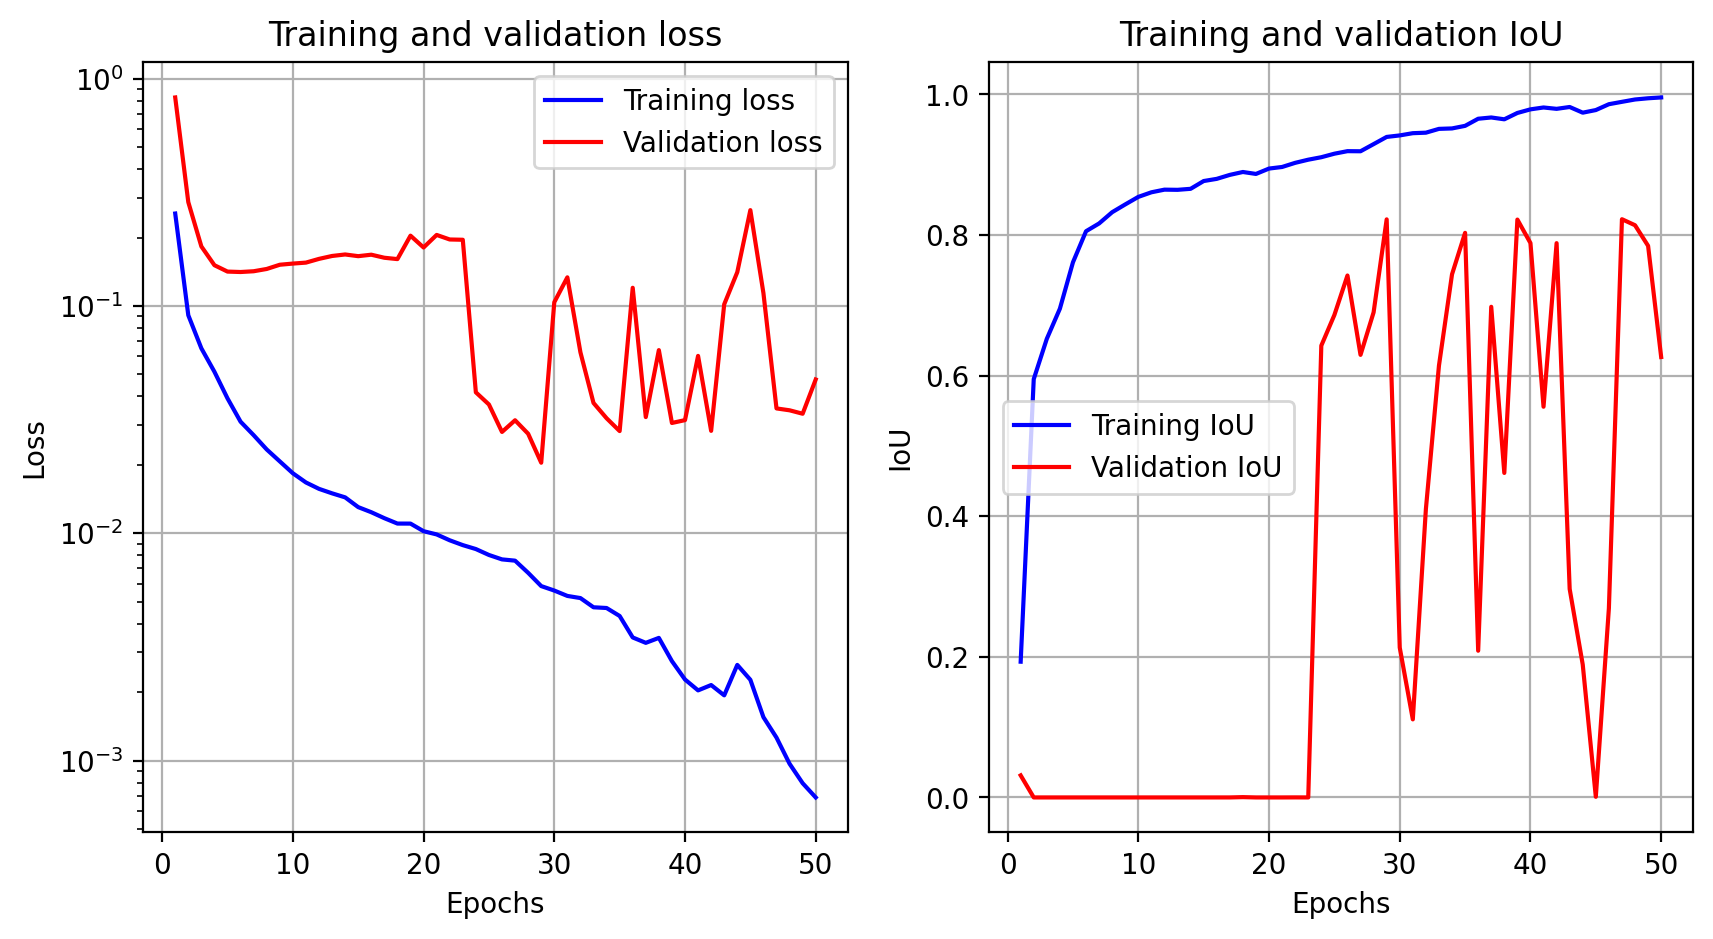

In [4]:
learning_progress(history)

In [5]:
# load best val_loss epoch 
best_model = tf.keras.models.load_model('edt2_64')

# predict ground probabilities for all test images
y_pred = best_model.predict(x_test)
# Convert sigmoid probability to classification
y_pred_thresholded = y_pred > 0.5

# IoU metrics
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_pred=y_pred_thresholded, y_true=y_test)

biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)

print("Mean IoU =", miou.result().numpy())
print("Binary IoU =", biou.result().numpy())

# only for ground
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 1 =", biou.result().numpy())

# only for non-ground pixel
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 0 =", biou.result().numpy())

2023-12-12 15:25:33.986602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 15:25:33.993498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 15:25:33.993660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

19/19 [==============================] - 6s 165ms/step
Mean IoU = 0.90754676
Binary IoU = 0.90754676
Binary IoU for class 1 = 0.8223046
Binary IoU for class 0 = 0.9927889


In [2]:
kf = 0

data = np.load("../labelmaking/all_scaled_EDT2_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0][kf::2]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0][kf::2]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0][kf::2]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0][kf::2]
y_test = np.expand_dims(y_test, axis=-1)

In [10]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib as mpl

k = 1
test_img = x_test[k]
prediction = best_model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


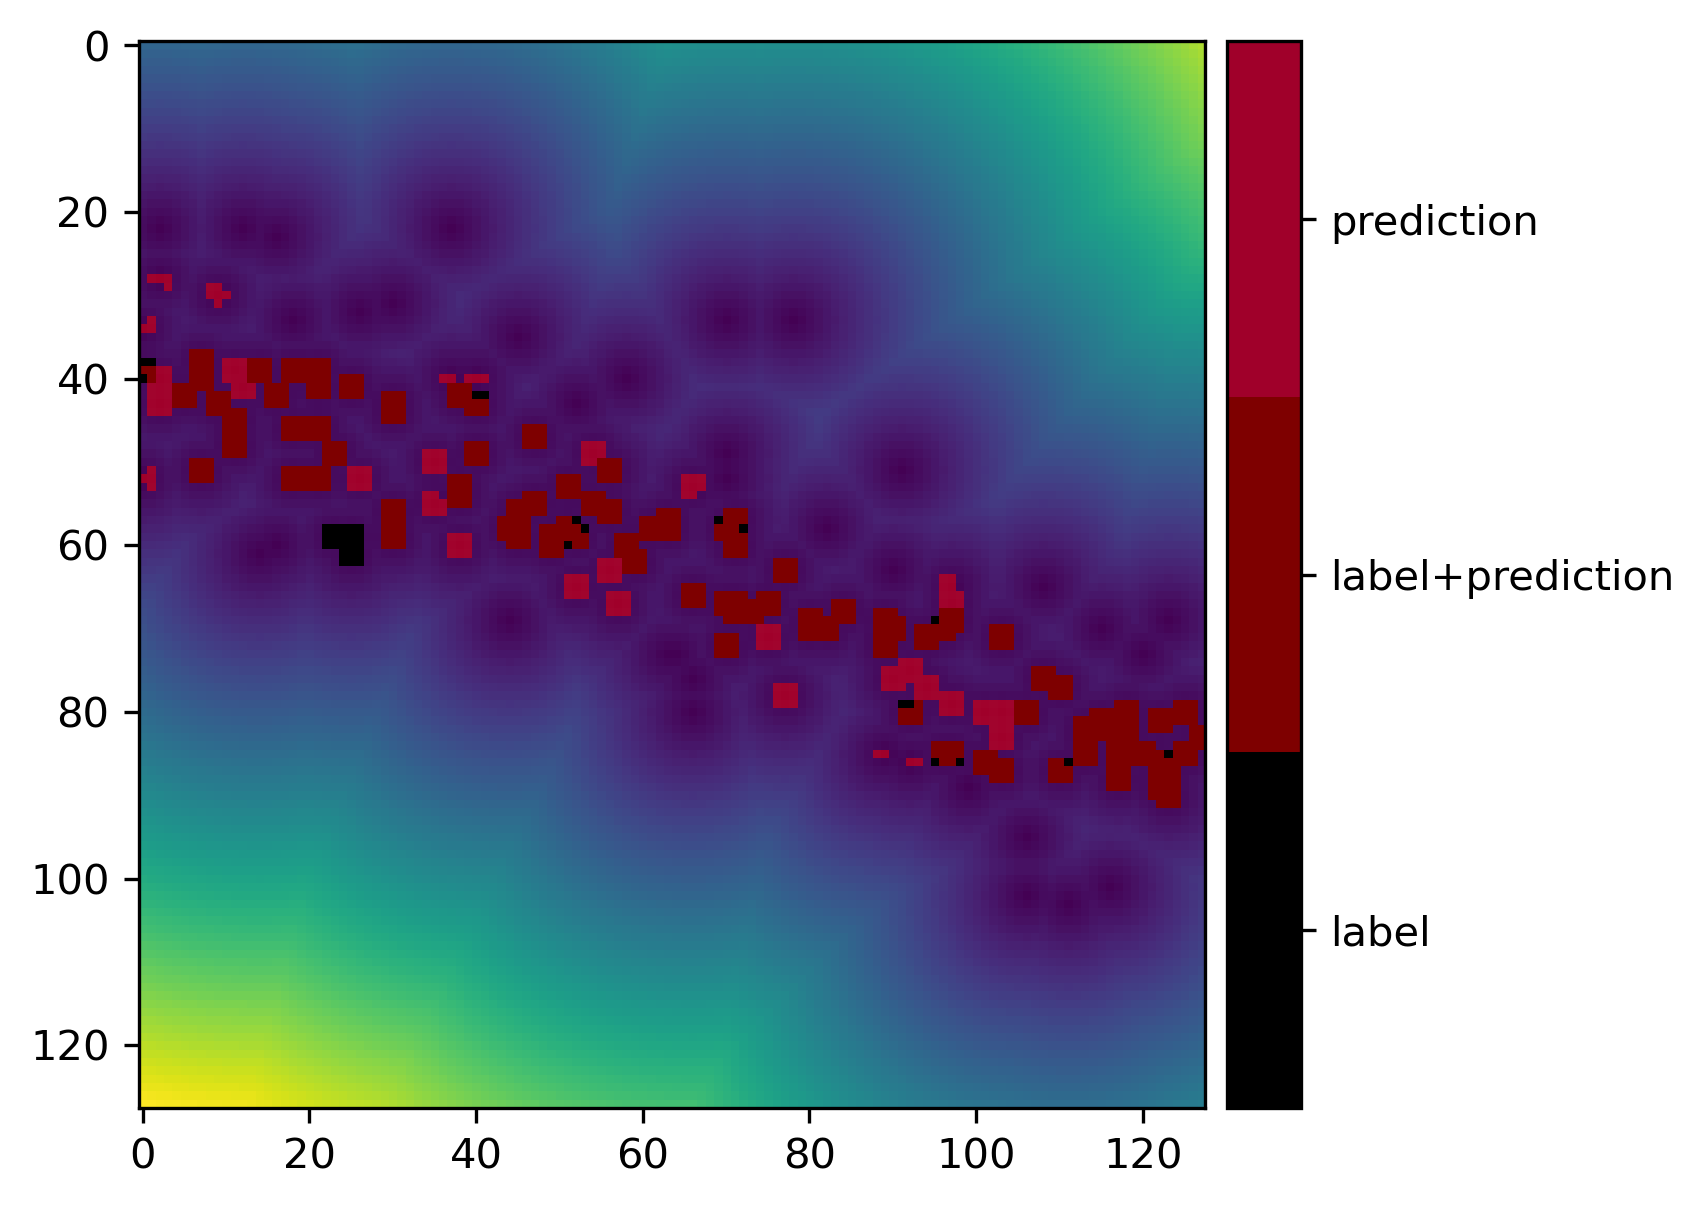

In [9]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib as mpl

k = 1
test_img = x_test[k]
prediction = best_model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(300)
# show background EDT
im = ax.imshow(np.abs(test_img[:,:,0]-np.max(test_img[:,:,0])))
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")
#cb = fig.colorbar(im, cax=cax, label='scaled EDT')

#cbar = fig.colorbar(im);
#cbar.set_ticks(ticks=[0.33,0.66,1], labels=[ 'FP', 'FN', 'TN'])

# show label
cmap1 = mpl.colors.ListedColormap(['none', 'black'])
ax.imshow(y_test[k], cmap=cmap1)

# show prediction
cmap2 = mpl.colors.ListedColormap(['none', 'red'])
ax.imshow(prediction > 0.5, cmap=cmap2, alpha=0.5);

cmap = mpl.colors.ListedColormap(['#000000', '#7e0000', '#a0002a'])
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),
             cax=cax, orientation='vertical', spacing='proportional')
cbar.set_ticks(ticks=[1/6,3/6,5/6], labels=['label', 'label+prediction', 'prediction'])

#plt.savefig('pred_example.png', bbox_inches='tight', transparent=True)

## EDT2 learning rate = 0.0005

In [3]:
kf = 0

data = np.load("../labelmaking/all_scaled_EDT2_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0][kf::2]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0][kf::2]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0][kf::2]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0][kf::2]
y_test = np.expand_dims(y_test, axis=-1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# unet architecture
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        input
    )
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# parameters 
input_shape = x_train.shape[1:]
batch_size = 64
learning_rate = 0.0005
epochs = 50

model = build_unet(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)],
)

checkpoint_filepath = 'edt2_00005_64'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback],
)

(2390, 128, 128, 1)
(597, 128, 128, 1)
(2390, 128, 128, 1)
(597, 128, 128, 1)


2023-11-02 14:17:46.956533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 14:17:46.967709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 14:17:46.967927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-11-02 14:17:51.974280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-02 14:17:52.031664: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-02 14:17:56.370992: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x31191660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-02 14:17:56.371013: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-02 14:17:56.374142: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-02 14:17:56.417124: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-02 14:17:56.453592: I ./tensorflow/compiler/jit/device_compiler.h:186] 

38/38 [==============================] - 51s 796ms/step - loss: 0.2144 - binary_io_u: 0.4020 - val_loss: 0.5064 - val_binary_io_u: 0.0000e+00
Epoch 2/50
38/38 [==============================] - 24s 637ms/step - loss: 0.0820 - binary_io_u: 0.6361 - val_loss: 0.3450 - val_binary_io_u: 1.1816e-05
Epoch 3/50
38/38 [==============================] - 24s 640ms/step - loss: 0.0600 - binary_io_u: 0.7003 - val_loss: 0.2413 - val_binary_io_u: 0.0050
Epoch 4/50
38/38 [==============================] - 24s 640ms/step - loss: 0.0488 - binary_io_u: 0.7531 - val_loss: 0.1779 - val_binary_io_u: 0.0000e+00
Epoch 5/50
38/38 [==============================] - 24s 639ms/step - loss: 0.0416 - binary_io_u: 0.7821 - val_loss: 0.1561 - val_binary_io_u: 0.0000e+00
Epoch 6/50
38/38 [==============================] - 24s 634ms/step - loss: 0.0349 - binary_io_u: 0.8042 - val_loss: 0.1476 - val_binary_io_u: 0.0000e+00
Epoch 7/50
38/38 [==============================] - 24s 638ms/step - loss: 0.0303 - binary_io_u: 

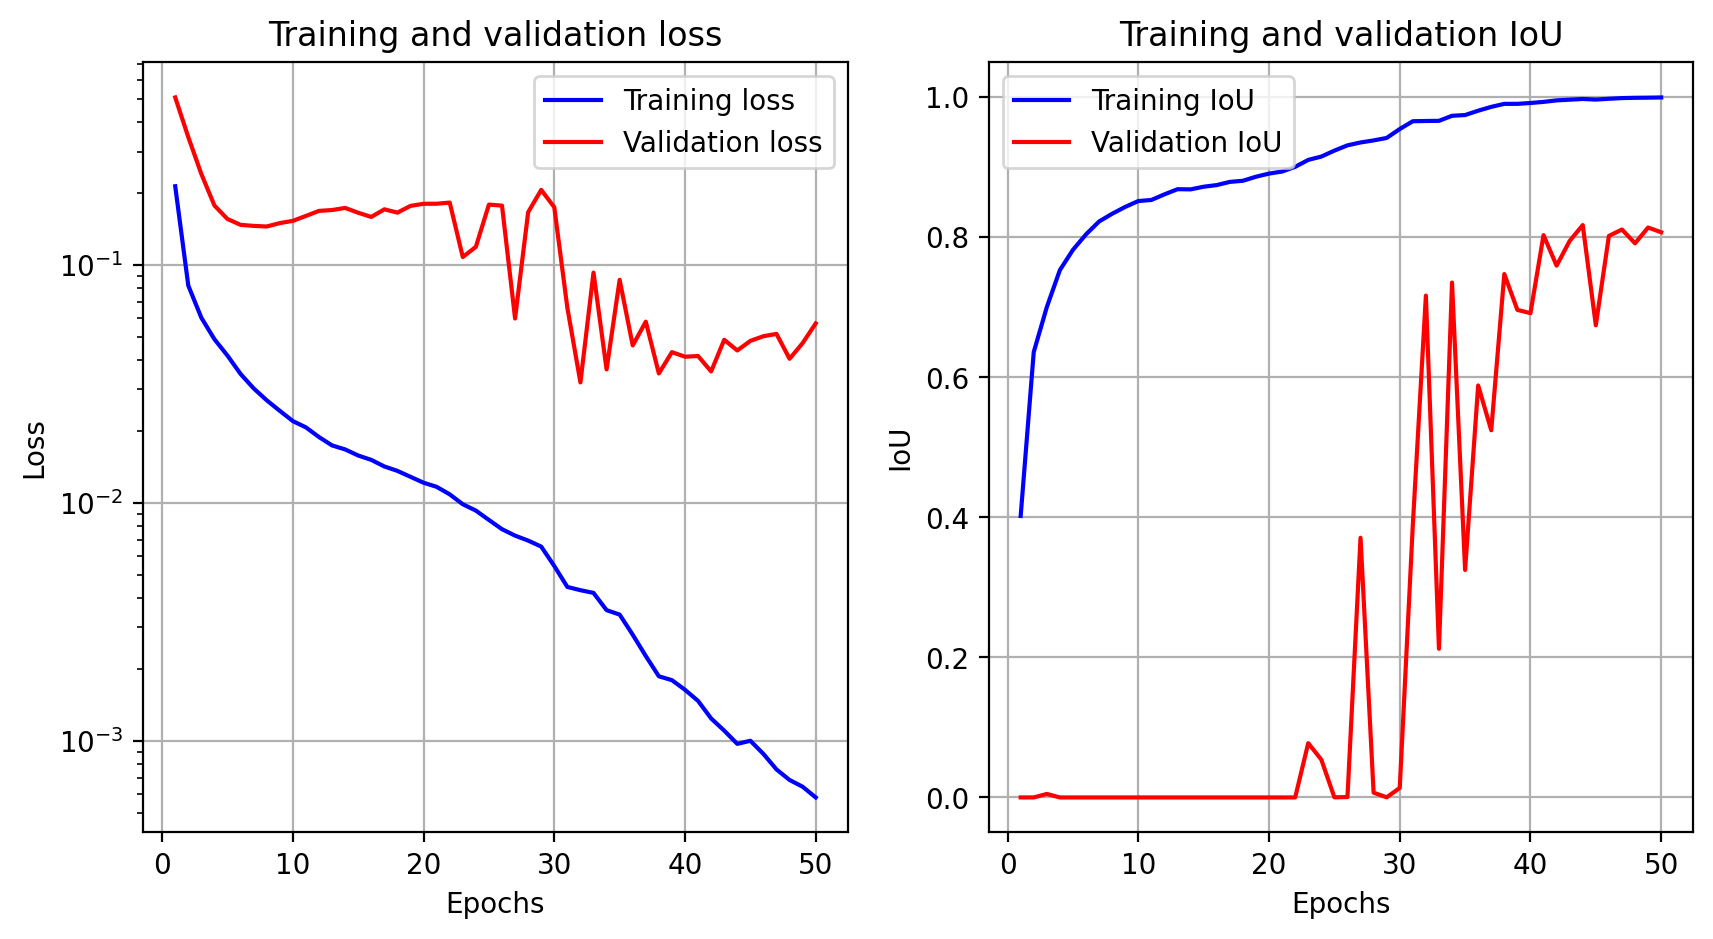

In [4]:
learning_progress(history)

In [5]:
# load best val_loss epoch 
best_model = tf.keras.models.load_model('edt2_00005_64')

# predict ground probabilities for all test images
y_pred = best_model.predict(x_test)
# Convert sigmoid probability to classification
y_pred_thresholded = y_pred > 0.5

# IoU metrics
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_pred=y_pred_thresholded, y_true=y_test)

biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)

print("Mean IoU =", miou.result().numpy())
print("Binary IoU =", biou.result().numpy())

# only for ground
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 1 =", biou.result().numpy())

# only for non-ground pixel
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 0 =", biou.result().numpy())

19/19 [==============================] - 4s 63ms/step
Mean IoU = 0.85262513
Binary IoU = 0.85262513
Binary IoU for class 1 = 0.7166955
Binary IoU for class 0 = 0.98855484


1/1 [==============================] - 1s 667ms/step


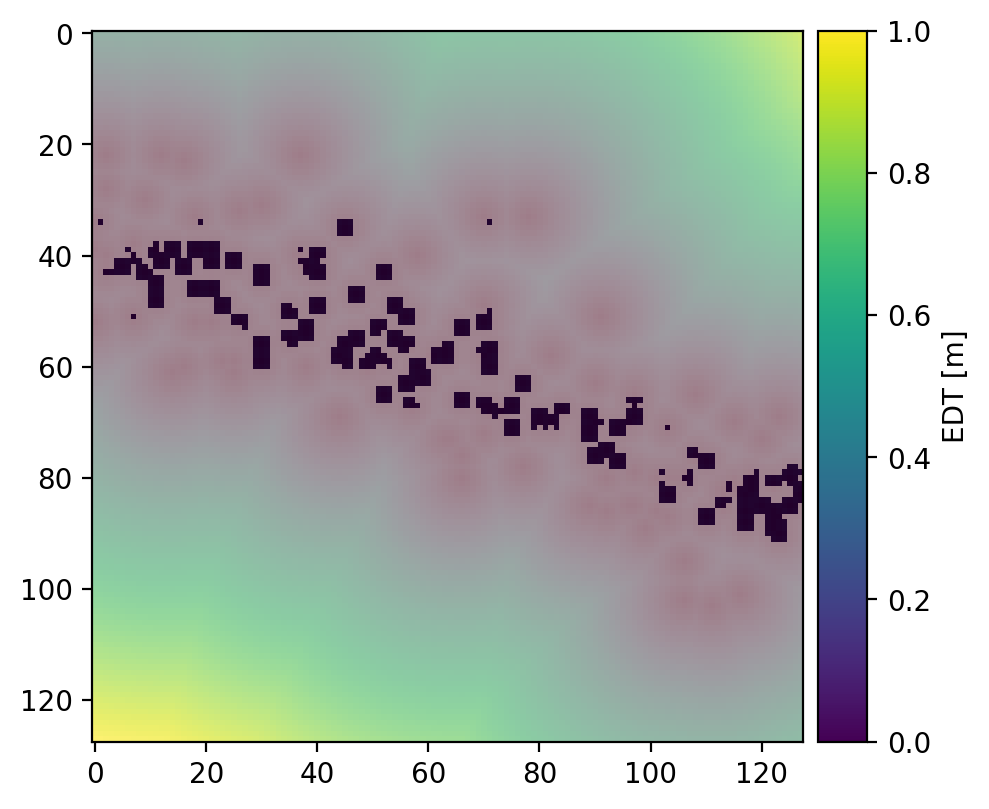

In [6]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

k = 1
test_img = x_test[k]
prediction = best_model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(200)
im = ax.imshow(np.abs(test_img[:,:,0]-np.max(test_img[:,:,0])))
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, label='EDT [m]')
ax.imshow(prediction > 0.5, cmap="magma_r", alpha=0.5);

## EDT2, learning rate = 0.0015

In [3]:
kf = 0

data = np.load("../labelmaking/all_scaled_EDT2_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0][kf::2]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0][kf::2]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0][kf::2]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0][kf::2]
y_test = np.expand_dims(y_test, axis=-1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# unet architecture
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        input
    )
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# parameters 
input_shape = x_train.shape[1:]
batch_size = 64
learning_rate = 0.0015
epochs = 50

model = build_unet(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)], 
)

checkpoint_filepath = 'edt2_00015_64'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback],
)

(2390, 128, 128, 1)
(597, 128, 128, 1)
(2390, 128, 128, 1)
(597, 128, 128, 1)


2023-11-02 14:39:54.235326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 14:39:54.242079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 14:39:54.242238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-11-02 14:39:59.268420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-02 14:39:59.326451: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-02 14:40:03.688831: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f35e061d360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-02 14:40:03.688855: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-02 14:40:03.692023: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-02 14:40:03.735709: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-02 14:40:03.772206: I ./tensorflow/compiler/jit/device_compiler.h:1

38/38 [==============================] - 51s 797ms/step - loss: 0.1845 - binary_io_u: 0.1834 - val_loss: 0.2923 - val_binary_io_u: 2.9617e-06
Epoch 2/50
38/38 [==============================] - 24s 634ms/step - loss: 0.0623 - binary_io_u: 0.5746 - val_loss: 0.1922 - val_binary_io_u: 0.0000e+00
Epoch 3/50
38/38 [==============================] - 24s 642ms/step - loss: 0.0441 - binary_io_u: 0.6506 - val_loss: 0.1649 - val_binary_io_u: 0.0000e+00
Epoch 4/50
38/38 [==============================] - 24s 640ms/step - loss: 0.0359 - binary_io_u: 0.6909 - val_loss: 0.1545 - val_binary_io_u: 0.0000e+00
Epoch 5/50
38/38 [==============================] - 24s 642ms/step - loss: 0.0302 - binary_io_u: 0.7248 - val_loss: 0.1487 - val_binary_io_u: 0.0000e+00
Epoch 6/50
38/38 [==============================] - 24s 641ms/step - loss: 0.0271 - binary_io_u: 0.7426 - val_loss: 0.1360 - val_binary_io_u: 0.0000e+00
Epoch 7/50
38/38 [==============================] - 17s 457ms/step - loss: 0.0214 - binary_io

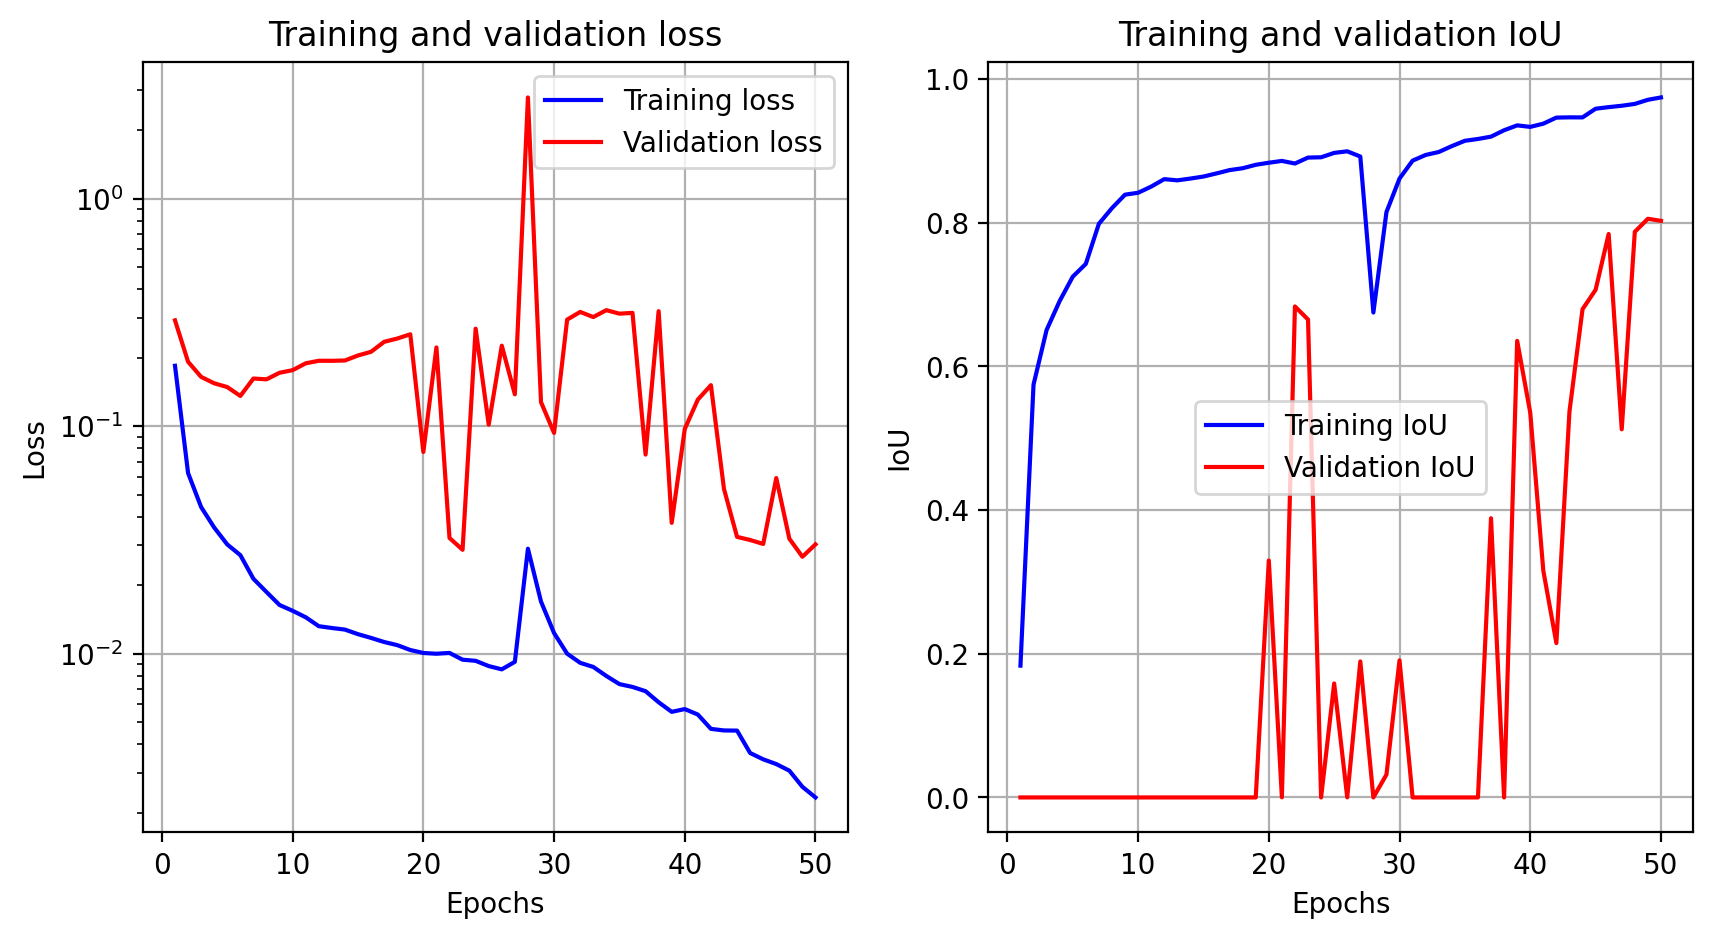

In [4]:
learning_progress(history)

In [5]:
# load best val_loss epoch 
best_model = tf.keras.models.load_model('edt2_00015_64')

# predict ground probabilities for all test images
y_pred = best_model.predict(x_test)
# Convert sigmoid probability to classification
y_pred_thresholded = y_pred > 0.5

# IoU metrics
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_pred=y_pred_thresholded, y_true=y_test)

biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)

print("Mean IoU =", miou.result().numpy())
print("Binary IoU =", biou.result().numpy())

# only for ground
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 1 =", biou.result().numpy())

# only for non-ground pixel
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 0 =", biou.result().numpy())

19/19 [==============================] - 4s 63ms/step
Mean IoU = 0.8989064
Binary IoU = 0.8989064
Binary IoU for class 1 = 0.8054195
Binary IoU for class 0 = 0.9923933


1/1 [==============================] - 1s 668ms/step


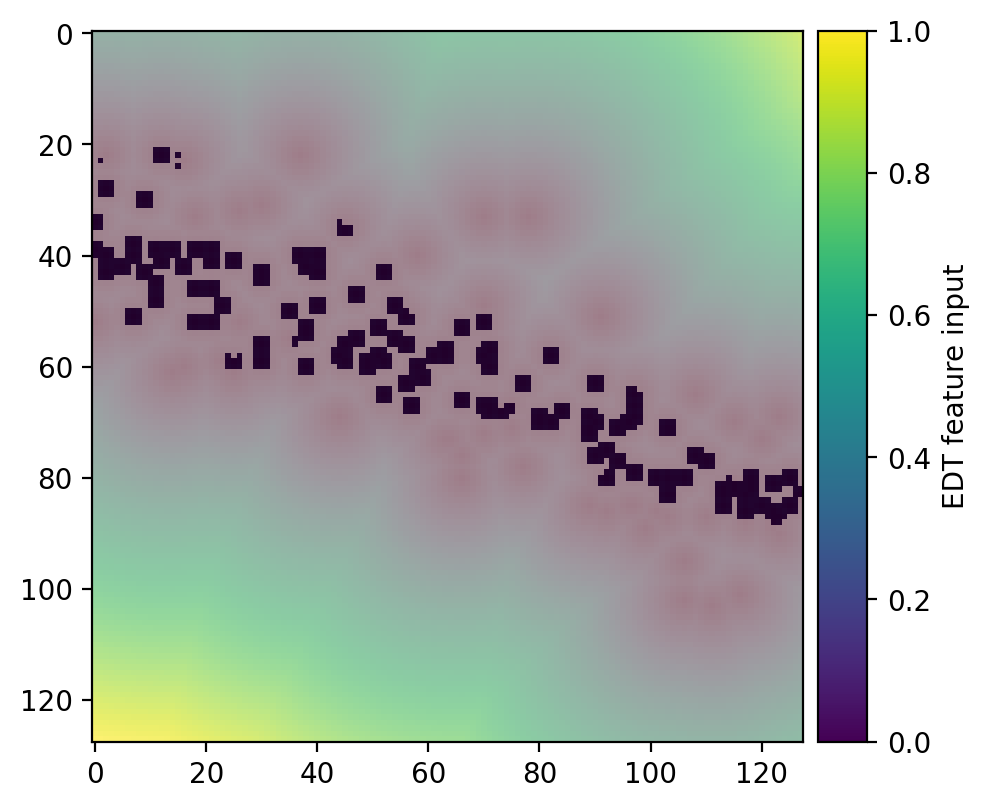

In [6]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

k = 1
test_img = x_test[k]
prediction = best_model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(200)
im = ax.imshow(np.abs(test_img[:,:,0]-np.max(test_img[:,:,0])))
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, label='EDT feature input')
ax.imshow(prediction > 0.5, cmap="magma_r", alpha=0.5);

## EDT3

In [4]:
kf = 0

data = np.load("../labelmaking/all_scaled_EDT3_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0][kf::2]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0][kf::2]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0][kf::2]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0][kf::2]
y_test = np.expand_dims(y_test, axis=-1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# unet architecture
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        input
    )
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# parameters 
input_shape = x_train.shape[1:]
batch_size = 64
learning_rate = 0.001
epochs = 50

model = build_unet(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)],
)

checkpoint_filepath = 'edt3_64'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback],
)

(2390, 128, 128, 1)
(597, 128, 128, 1)
(2390, 128, 128, 1)
(597, 128, 128, 1)


2023-10-05 13:58:02.973543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 13:58:02.982531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 13:58:02.982723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-10-05 13:58:07.837395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 13:58:07.895276: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 13:58:12.247367: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5a16b3c280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 13:58:12.247387: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-10-05 13:58:12.250736: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-05 13:58:12.295640: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 13:58:12.332074: I ./tensorflow/compiler/jit/device_compiler.h:1

38/38 [==============================] - 51s 798ms/step - loss: 0.1720 - binary_io_u: 0.5471 - val_loss: 0.9216 - val_binary_io_u: 0.0696
Epoch 2/50
38/38 [==============================] - 24s 650ms/step - loss: 0.0625 - binary_io_u: 0.7604 - val_loss: 0.3488 - val_binary_io_u: 8.9804e-04
Epoch 3/50
38/38 [==============================] - 24s 645ms/step - loss: 0.0499 - binary_io_u: 0.7760 - val_loss: 0.2353 - val_binary_io_u: 0.0000e+00
Epoch 4/50
38/38 [==============================] - 24s 639ms/step - loss: 0.0427 - binary_io_u: 0.7934 - val_loss: 0.2173 - val_binary_io_u: 0.0000e+00
Epoch 5/50
38/38 [==============================] - 17s 454ms/step - loss: 0.0373 - binary_io_u: 0.8092 - val_loss: 0.2382 - val_binary_io_u: 0.0000e+00
Epoch 6/50
38/38 [==============================] - 17s 456ms/step - loss: 0.0332 - binary_io_u: 0.8243 - val_loss: 0.2608 - val_binary_io_u: 0.0000e+00
Epoch 7/50
38/38 [==============================] - 17s 457ms/step - loss: 0.0309 - binary_io_u: 

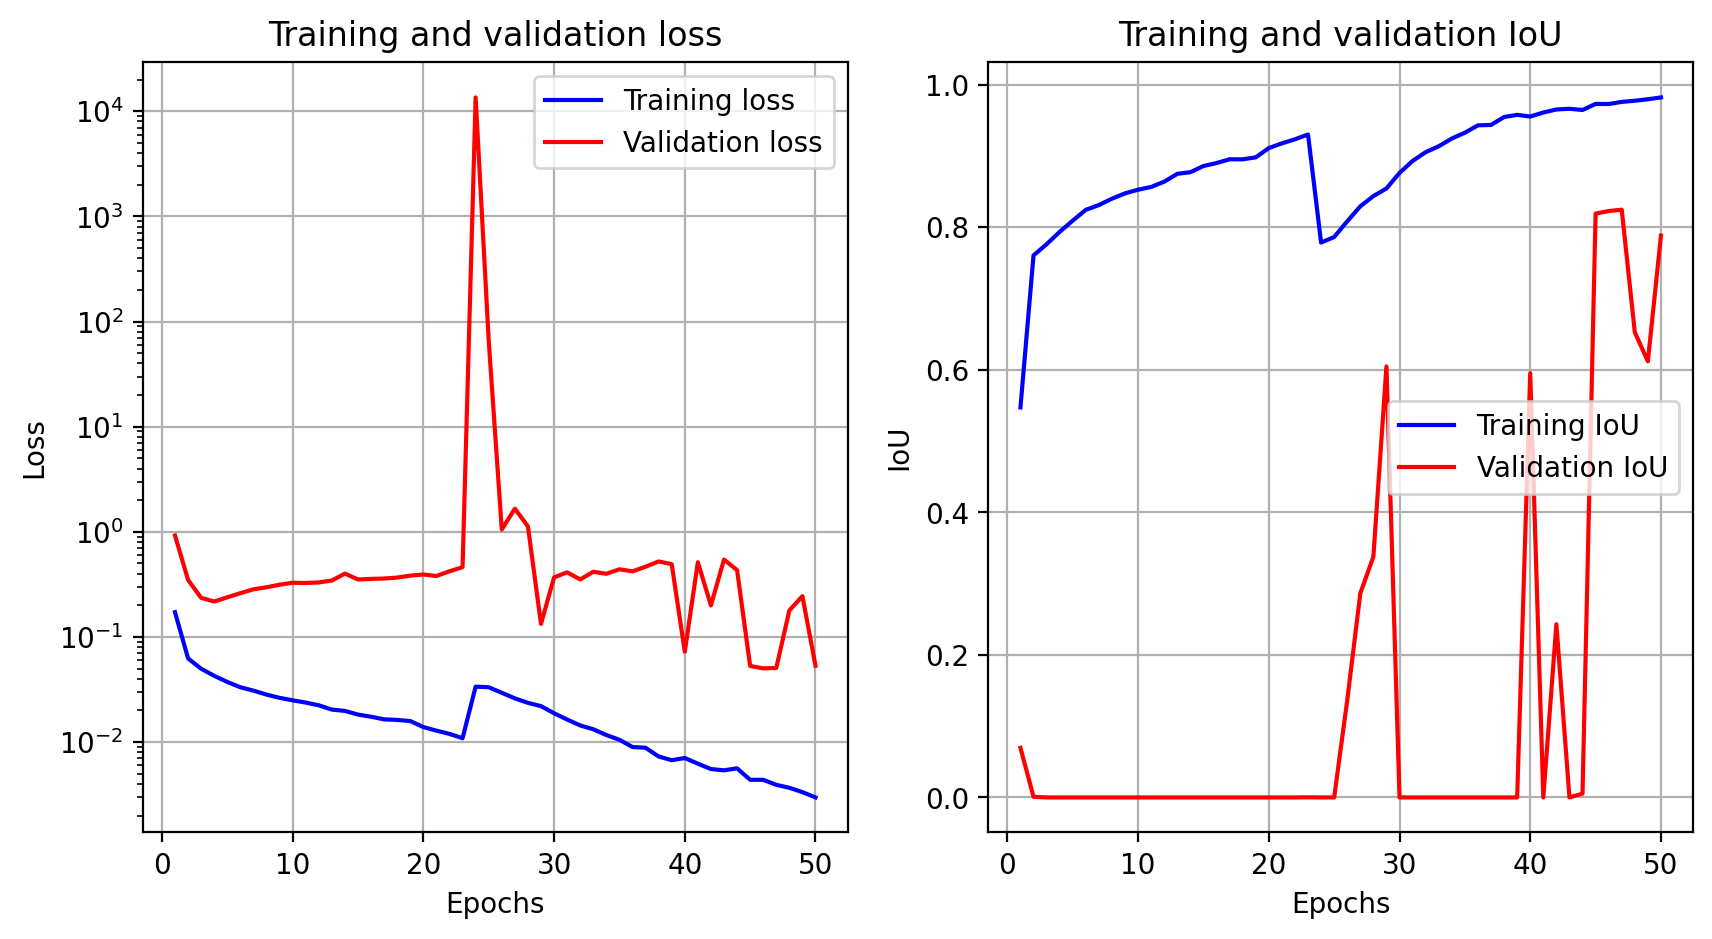

In [5]:
learning_progress(history)

In [6]:
# load best val_loss epoch 
best_model = tf.keras.models.load_model('edt3_64')

# predict ground probabilities for all test images
y_pred = best_model.predict(x_test)
# Convert sigmoid probability to classification
y_pred_thresholded = y_pred > 0.5

# IoU metrics
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_pred=y_pred_thresholded, y_true=y_test)

biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)

print("Mean IoU =", miou.result().numpy())
print("Binary IoU =", biou.result().numpy())

# only for ground
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 1 =", biou.result().numpy())

# only for non-ground pixel
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 0 =", biou.result().numpy())

19/19 [==============================] - 4s 63ms/step
Mean IoU = 0.9046704
Binary IoU = 0.9046704
Binary IoU for class 1 = 0.8225739
Binary IoU for class 0 = 0.98676693


1/1 [==============================] - 1s 669ms/step


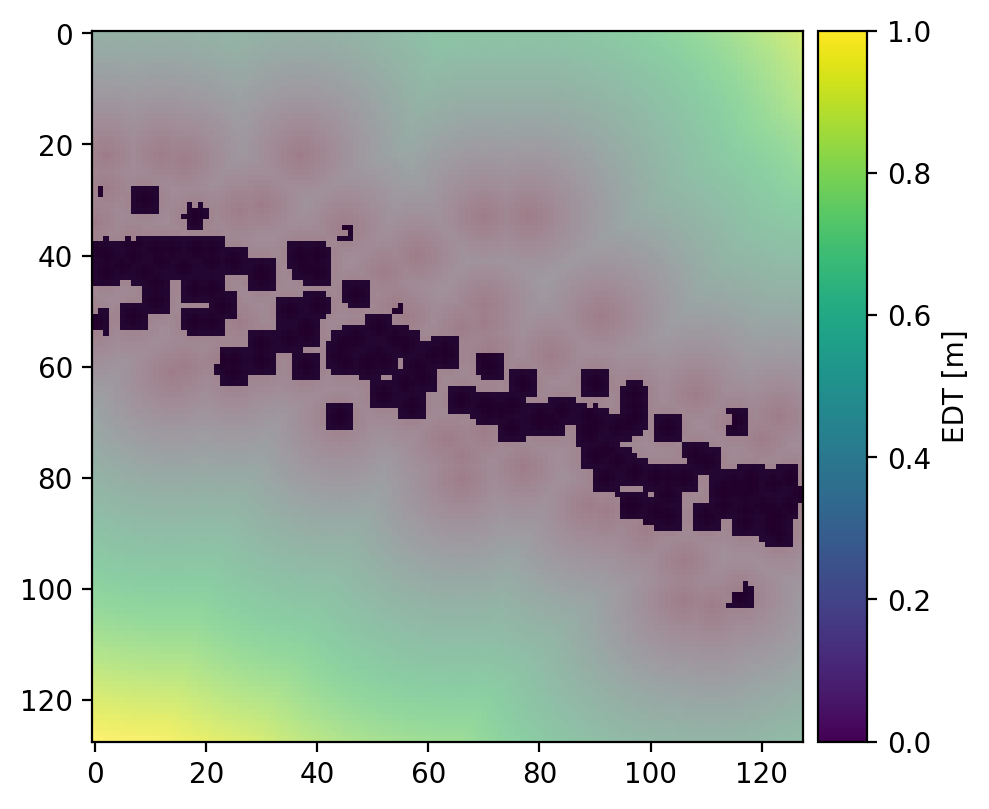

In [7]:
k = 1
test_img = x_test[k]
prediction = best_model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(200)
im = ax.imshow(np.abs(test_img[:,:,0]-np.max(test_img[:,:,0])))
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, label='EDT [m]')
ax.imshow(prediction > 0.5, cmap="magma_r", alpha=0.5);

## EDT4

In [3]:
kf = 0

data = np.load("../labelmaking/all_scaled_EDT4_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0][kf::2]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0][kf::2]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0][kf::2]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0][kf::2]
y_test = np.expand_dims(y_test, axis=-1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# unet architecture
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        input
    )
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# parameters 
input_shape = x_train.shape[1:]
batch_size = 64
learning_rate = 0.001
epochs = 50

model = build_unet(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)], 
)

checkpoint_filepath = 'edt4_64'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback],
)

(2390, 128, 128, 1)
(597, 128, 128, 1)
(2390, 128, 128, 1)
(597, 128, 128, 1)


2023-10-05 14:17:36.422410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 14:17:36.427019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 14:17:36.427131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-10-05 14:17:41.422404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 14:17:41.479947: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 14:17:45.855232: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb12c12a9e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 14:17:45.855252: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-10-05 14:17:45.858414: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-05 14:17:45.901935: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 14:17:45.938858: I ./tensorflow/compiler/jit/device_compiler.h:1

38/38 [==============================] - 52s 809ms/step - loss: 0.2149 - binary_io_u: 0.5560 - val_loss: 176.2762 - val_binary_io_u: 0.0837
Epoch 2/50
38/38 [==============================] - 24s 647ms/step - loss: 0.0802 - binary_io_u: 0.7997 - val_loss: 13.0990 - val_binary_io_u: 0.0840
Epoch 3/50
38/38 [==============================] - 24s 644ms/step - loss: 0.0615 - binary_io_u: 0.8149 - val_loss: 0.3818 - val_binary_io_u: 0.0000e+00
Epoch 4/50
38/38 [==============================] - 24s 639ms/step - loss: 0.0512 - binary_io_u: 0.8264 - val_loss: 0.2918 - val_binary_io_u: 0.0000e+00
Epoch 5/50
38/38 [==============================] - 17s 456ms/step - loss: 0.0454 - binary_io_u: 0.8317 - val_loss: 0.3196 - val_binary_io_u: 0.0000e+00
Epoch 6/50
38/38 [==============================] - 17s 458ms/step - loss: 0.0389 - binary_io_u: 0.8485 - val_loss: 0.3583 - val_binary_io_u: 0.0000e+00
Epoch 7/50
38/38 [==============================] - 17s 458ms/step - loss: 0.0353 - binary_io_u: 0

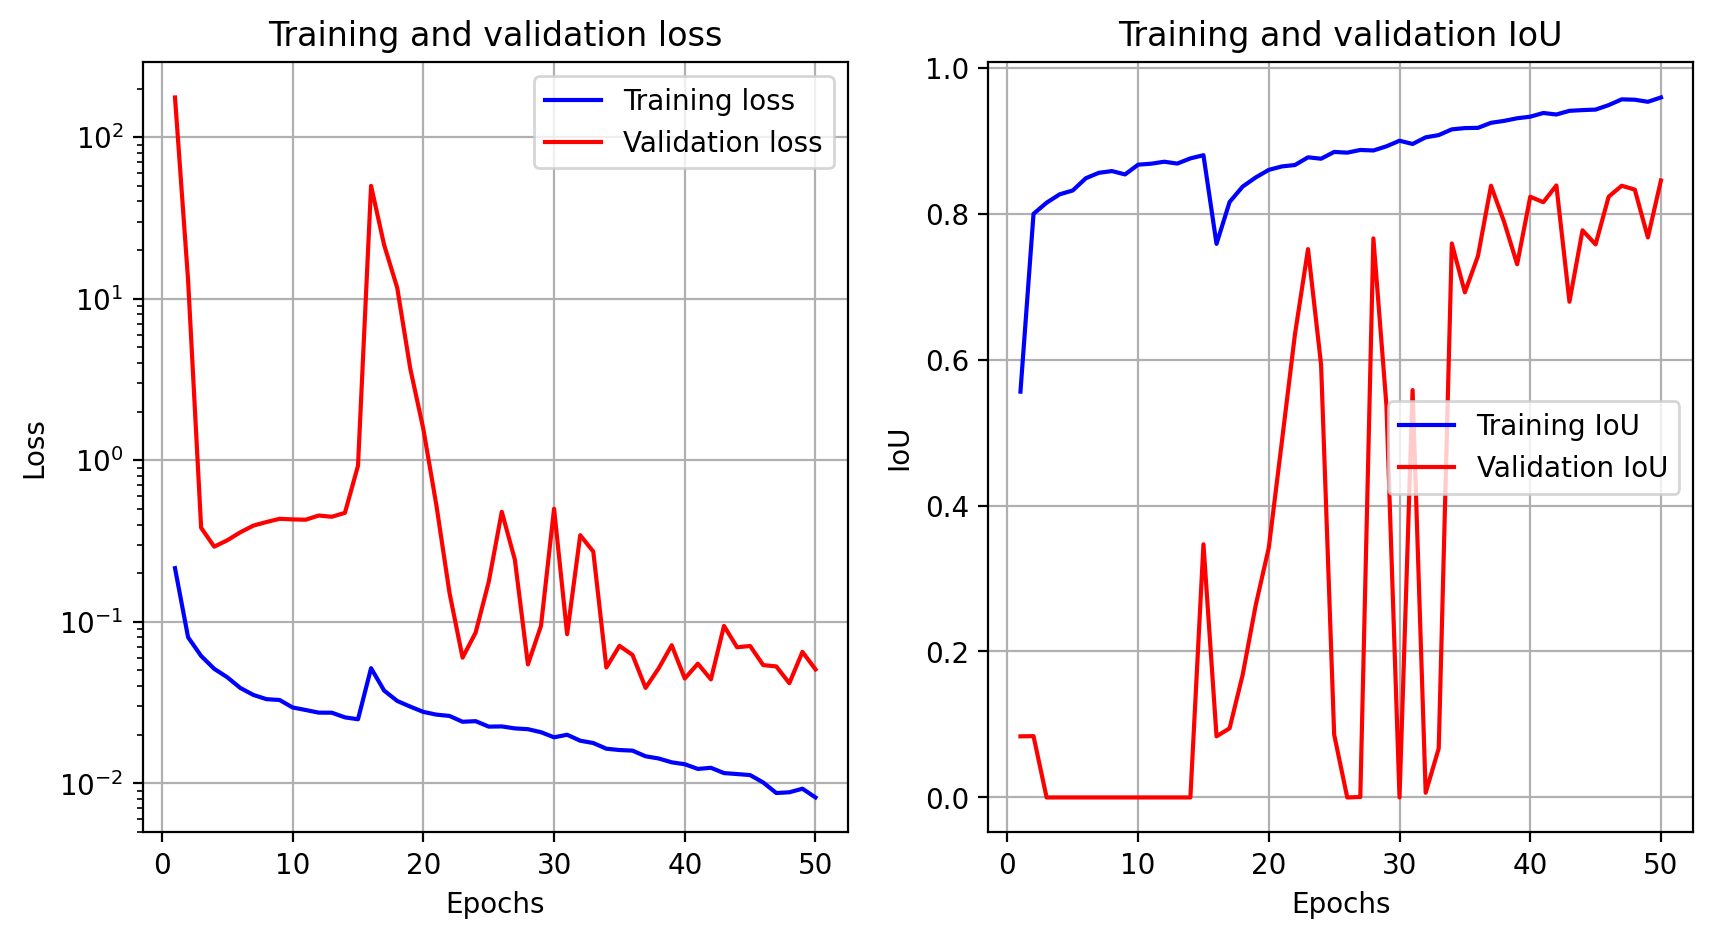

In [4]:
learning_progress(history)

In [5]:
# load best val_loss epoch 
best_model = tf.keras.models.load_model('edt4_64')

# predict ground probabilities for all test images
y_pred = best_model.predict(x_test)
# Convert sigmoid probability to classification
y_pred_thresholded = y_pred > 0.5

# IoU metrics
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_pred=y_pred_thresholded, y_true=y_test)

biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)

print("Mean IoU =", miou.result().numpy())
print("Binary IoU =", biou.result().numpy())

# only for ground
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 1 =", biou.result().numpy())

# only for non-ground pixel
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 0 =", biou.result().numpy())

19/19 [==============================] - 4s 63ms/step
Mean IoU = 0.9112332
Binary IoU = 0.9112332
Binary IoU for class 1 = 0.83820605
Binary IoU for class 0 = 0.9842604


1/1 [==============================] - 1s 675ms/step


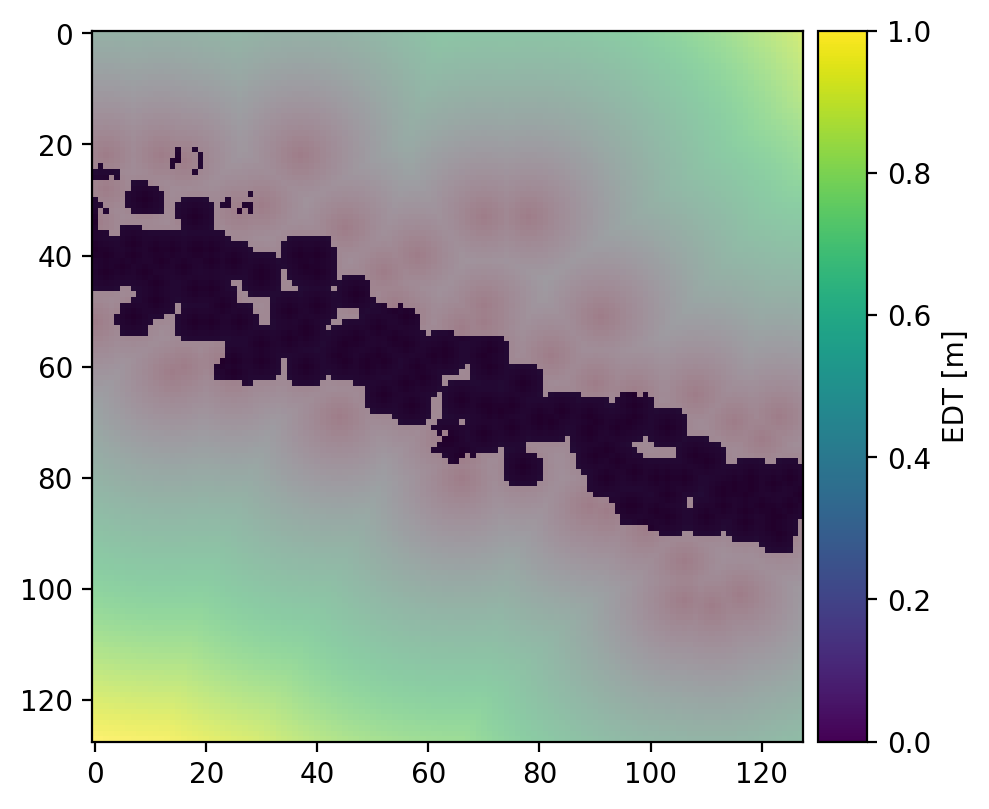

In [6]:
k = 1
test_img = x_test[k]
prediction = best_model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(200)
im = ax.imshow(np.abs(test_img[:,:,0]-np.max(test_img[:,:,0])))
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, label='EDT [m]')
ax.imshow(prediction > 0.5, cmap="magma_r", alpha=0.5);

## EDT5

In [3]:
kf = 0

data = np.load("../labelmaking/all_scaled_EDT5_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0][kf::2]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0][kf::2]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0][kf::2]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0][kf::2]
y_test = np.expand_dims(y_test, axis=-1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# unet architecture
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        input
    )
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# parameters 
input_shape = x_train.shape[1:]
batch_size = 64
learning_rate = 0.001
epochs = 50

model = build_unet(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)], 
)

checkpoint_filepath = 'edt5_64'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback],
)

(2390, 128, 128, 1)
(597, 128, 128, 1)
(2390, 128, 128, 1)
(597, 128, 128, 1)


2023-10-05 14:47:24.640898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 14:47:24.645502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 14:47:24.645612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-10-05 14:47:29.532585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 14:47:29.591085: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 14:47:33.933999: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1b6012b4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 14:47:33.934020: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-10-05 14:47:33.937118: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-05 14:47:33.980527: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 14:47:34.017278: I ./tensorflow/compiler/jit/device_compiler.h:1

38/38 [==============================] - 51s 797ms/step - loss: 0.1312 - binary_io_u: 0.7096 - val_loss: 1.1689 - val_binary_io_u: 0.1173
Epoch 2/50
38/38 [==============================] - 24s 640ms/step - loss: 0.0565 - binary_io_u: 0.8348 - val_loss: 0.3316 - val_binary_io_u: 0.3482
Epoch 3/50
38/38 [==============================] - 17s 453ms/step - loss: 0.0468 - binary_io_u: 0.8427 - val_loss: 0.3683 - val_binary_io_u: 0.0000e+00
Epoch 4/50
38/38 [==============================] - 17s 455ms/step - loss: 0.0415 - binary_io_u: 0.8496 - val_loss: 0.4095 - val_binary_io_u: 0.0000e+00
Epoch 5/50
38/38 [==============================] - 17s 456ms/step - loss: 0.0368 - binary_io_u: 0.8608 - val_loss: 0.4626 - val_binary_io_u: 0.0000e+00
Epoch 6/50
38/38 [==============================] - 17s 457ms/step - loss: 0.0346 - binary_io_u: 0.8655 - val_loss: 0.5024 - val_binary_io_u: 0.0000e+00
Epoch 7/50
38/38 [==============================] - 17s 457ms/step - loss: 0.0318 - binary_io_u: 0.87

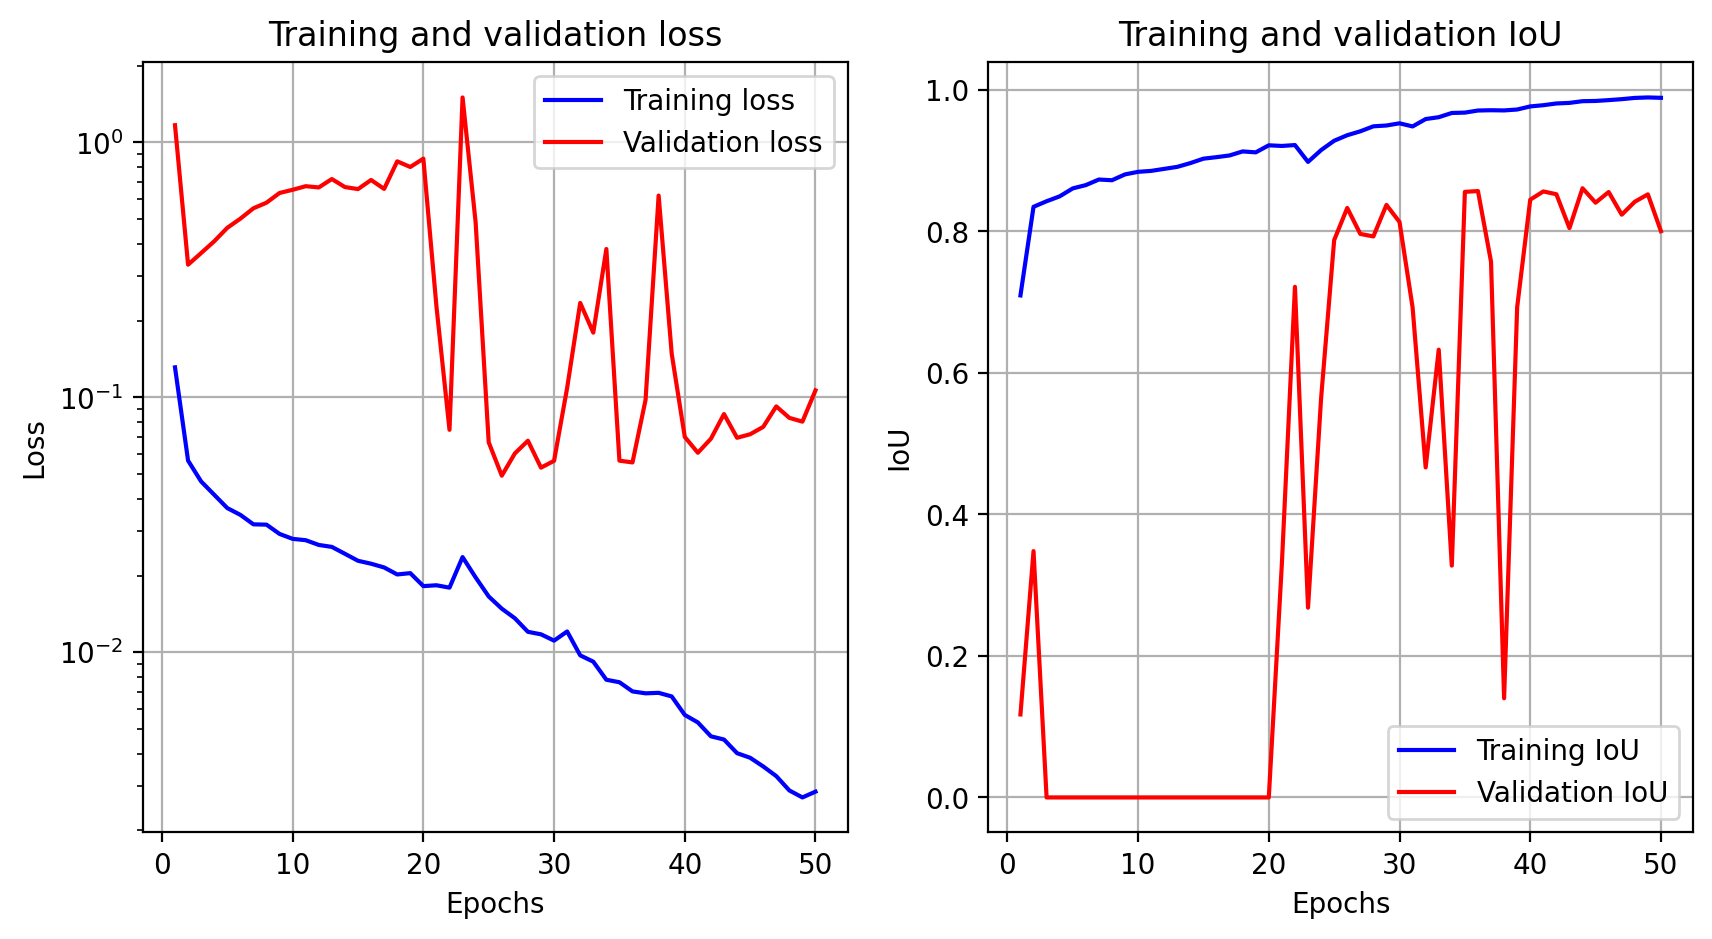

In [4]:
learning_progress(history)

In [5]:
# load best val_loss epoch 
best_model = tf.keras.models.load_model('edt5_64')

# predict ground probabilities for all test images
y_pred = best_model.predict(x_test)
# Convert sigmoid probability to classification
y_pred_thresholded = y_pred > 0.5

# IoU metrics
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_pred=y_pred_thresholded, y_true=y_test)

biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)

print("Mean IoU =", miou.result().numpy())
print("Binary IoU =", biou.result().numpy())

# only for ground
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 1 =", biou.result().numpy())

# only for non-ground pixel
biou = tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)
biou.update_state(y_pred=y_pred, y_true=y_test)
print("Binary IoU for class 0 =", biou.result().numpy())

19/19 [==============================] - 4s 63ms/step
Mean IoU = 0.9066528
Binary IoU = 0.9066528
Binary IoU for class 1 = 0.83319825
Binary IoU for class 0 = 0.98010737


1/1 [==============================] - 1s 651ms/step


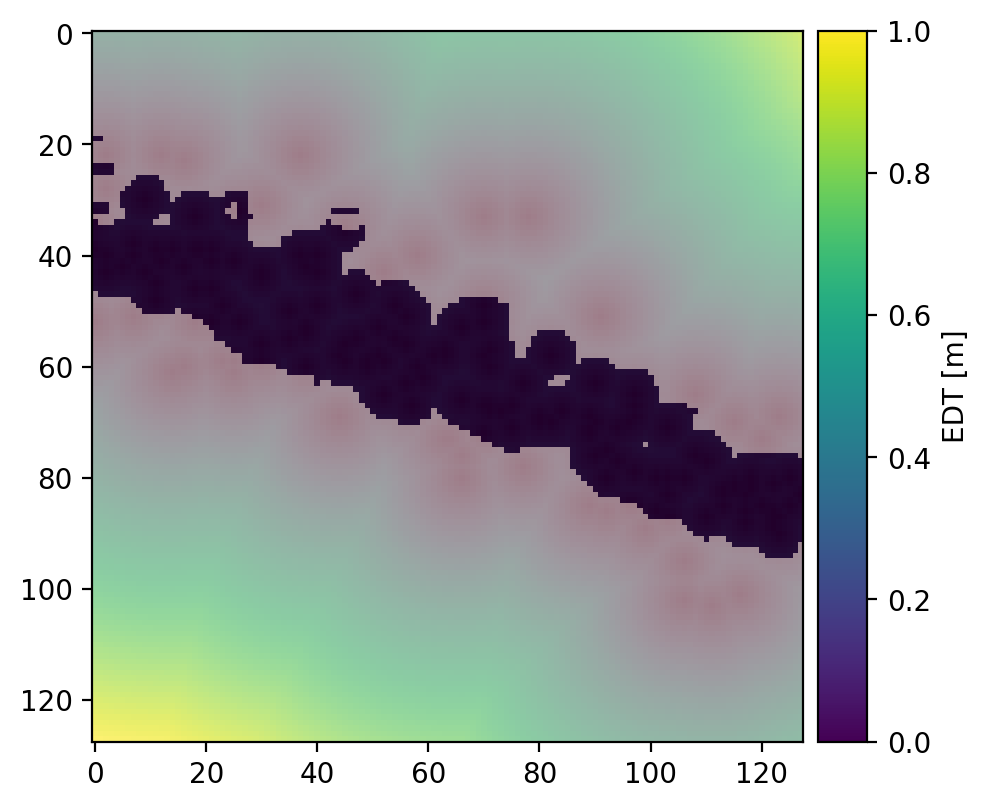

In [6]:
k = 1
test_img = x_test[k]
prediction = best_model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(200)
im = ax.imshow(np.abs(test_img[:,:,0]-np.max(test_img[:,:,0])))
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, label='EDT [m]')
ax.imshow(prediction > 0.5, cmap="magma_r", alpha=0.5);

## prediction images

In [ ]:
data = np.load("../labelmaking/all_scaled_train_label_EDT5_0_30726_res64_s5.npz")

edt = data['train'][:,:,:,0]
edt = np.expand_dims(edt, axis=-1)

best_model = tf.keras.models.load_model('edt5_64')

train_pred = best_model.predict(edt)
train_pred_thresholded = train_pred > 0.5

np.savez_compressed("../Photon_IoU/all_predicted_scaled_EDT5_res64_order", pred=train_pred_thresholded)

In [9]:
# load data and best model
data = np.load("../labelmaking/all_scaled_EDT5_res64_concat_s5.npz")
x_train = data["x_train"][:,:,:,0]
x_train = np.expand_dims(x_train, axis=-1)
x_test = data["x_test"][:,:,:,0]
x_test = np.expand_dims(x_test, axis=-1)
y_train = data["y_train"][:,:,:,0]
y_train = np.expand_dims(y_train, axis=-1)
y_test = data["y_test"][:,:,:,0]
y_test = np.expand_dims(y_test, axis=-1)
best_model = tf.keras.models.load_model('edt5_64')

# prediction images
# predict ground probabilities for all train images
train_pred = best_model.predict(x_train)
# Convert sigmoid probability to classification
train_pred_thresholded = train_pred > 0.5

150/150 [==============================] - 10s 67ms/step


In [10]:
# predict ground probabilities for all test images
test_pred = best_model.predict(x_test)
# Convert sigmoid probability to classification
test_pred_thresholded = test_pred > 0.5

# load divider indices
ind_test = np.load('../labelmaking/all_concat_64_s5_indices_test.npy')
ind_train = np.load('../labelmaking/all_concat_64_s5_indices_train.npy')
ind_all = np.load('../labelmaking/all_concat_64_s5_indices.npy')

# divide
test_pred_mtns = test_pred_thresholded[:ind_test[0]]
test_pred_fhills = test_pred_thresholded[ind_test[0]:ind_test[1]]
test_pred_plains = test_pred_thresholded[ind_test[1]:]

train_pred_mtns =   train_pred_thresholded[:ind_train[0]]
train_pred_fhills = train_pred_thresholded[ind_train[0]:ind_train[1]]
train_pred_plains = train_pred_thresholded[ind_train[1]:]

# concatenate
all_predicted = np.concatenate((test_pred_mtns, train_pred_mtns, test_pred_fhills, train_pred_fhills, test_pred_plains, train_pred_plains))
print(all_predicted.shape)

np.savez_compressed("../Photon_IoU/all_predicted_scaled_EDT5_res64", pred=all_predicted)

38/38 [==============================] - 3s 67ms/step
(5974, 128, 128, 1)
